In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from utils import data_load
from dateutil.parser import parse as parse_date
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import statsmodels.api as sm
from scipy import stats

import matplotlib as mpl
%matplotlib inline

/opt/homebrew/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
sns.set_style("whitegrid")

In [4]:
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['font.family'] = 'Serif'
sns.set_style({'font.family': 'Times New Roman'})

In [5]:
from features_engineering import feature_and_regression as fr

In [6]:
SUCCESS_THRESHOLD = 7.5
BAD_THRESHOLD = 6.5

In [7]:
country_df = pd.read_pickle("../data/post_processing//country_df.pkl")
comes_from_df = pd.read_pickle("../data/post_processing/comes_from_df.pkl")
genre_df = pd.read_pickle("../data/post_processing/genre_df.pkl")
is_of_type_df = pd.read_pickle("../data/post_processing/is_of_type_df.pkl")
language_df = pd.read_pickle("../data/post_processing/language_df.pkl")
spoken_languages_df = pd.read_pickle("../data/post_processing/spoken_languages_df.pkl")
character_df = pd.read_pickle("../data/post_processing/character_df.pkl")
actor_df = pd.read_pickle("../data/post_processing/actor_df.pkl")
movie_df = pd.read_pickle("../data/post_processing/movie_df.pkl")
belongs_to_df = pd.read_pickle("../data/post_processing/belongs_to_df.pkl")
play_df = pd.read_pickle("../data/post_processing/play_df.pkl")
appears_in_df = pd.read_pickle("../data/post_processing/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../data/generated/wikipedia_imdb_mapping_df.pkl")
is_directed_by_df = pd.read_pickle("../data/post_processing/is_directed_by_df.pkl")
director_df = pd.read_pickle("../data/post_processing/director_df.pkl")

In [8]:
ratings = data_load.load_imdb_title_ratings()
ratings.head()

,tconst,average_rating,num_votes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1735
3,tt0000004,5.6,174
4,tt0000005,6.2,2548


In [9]:
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True

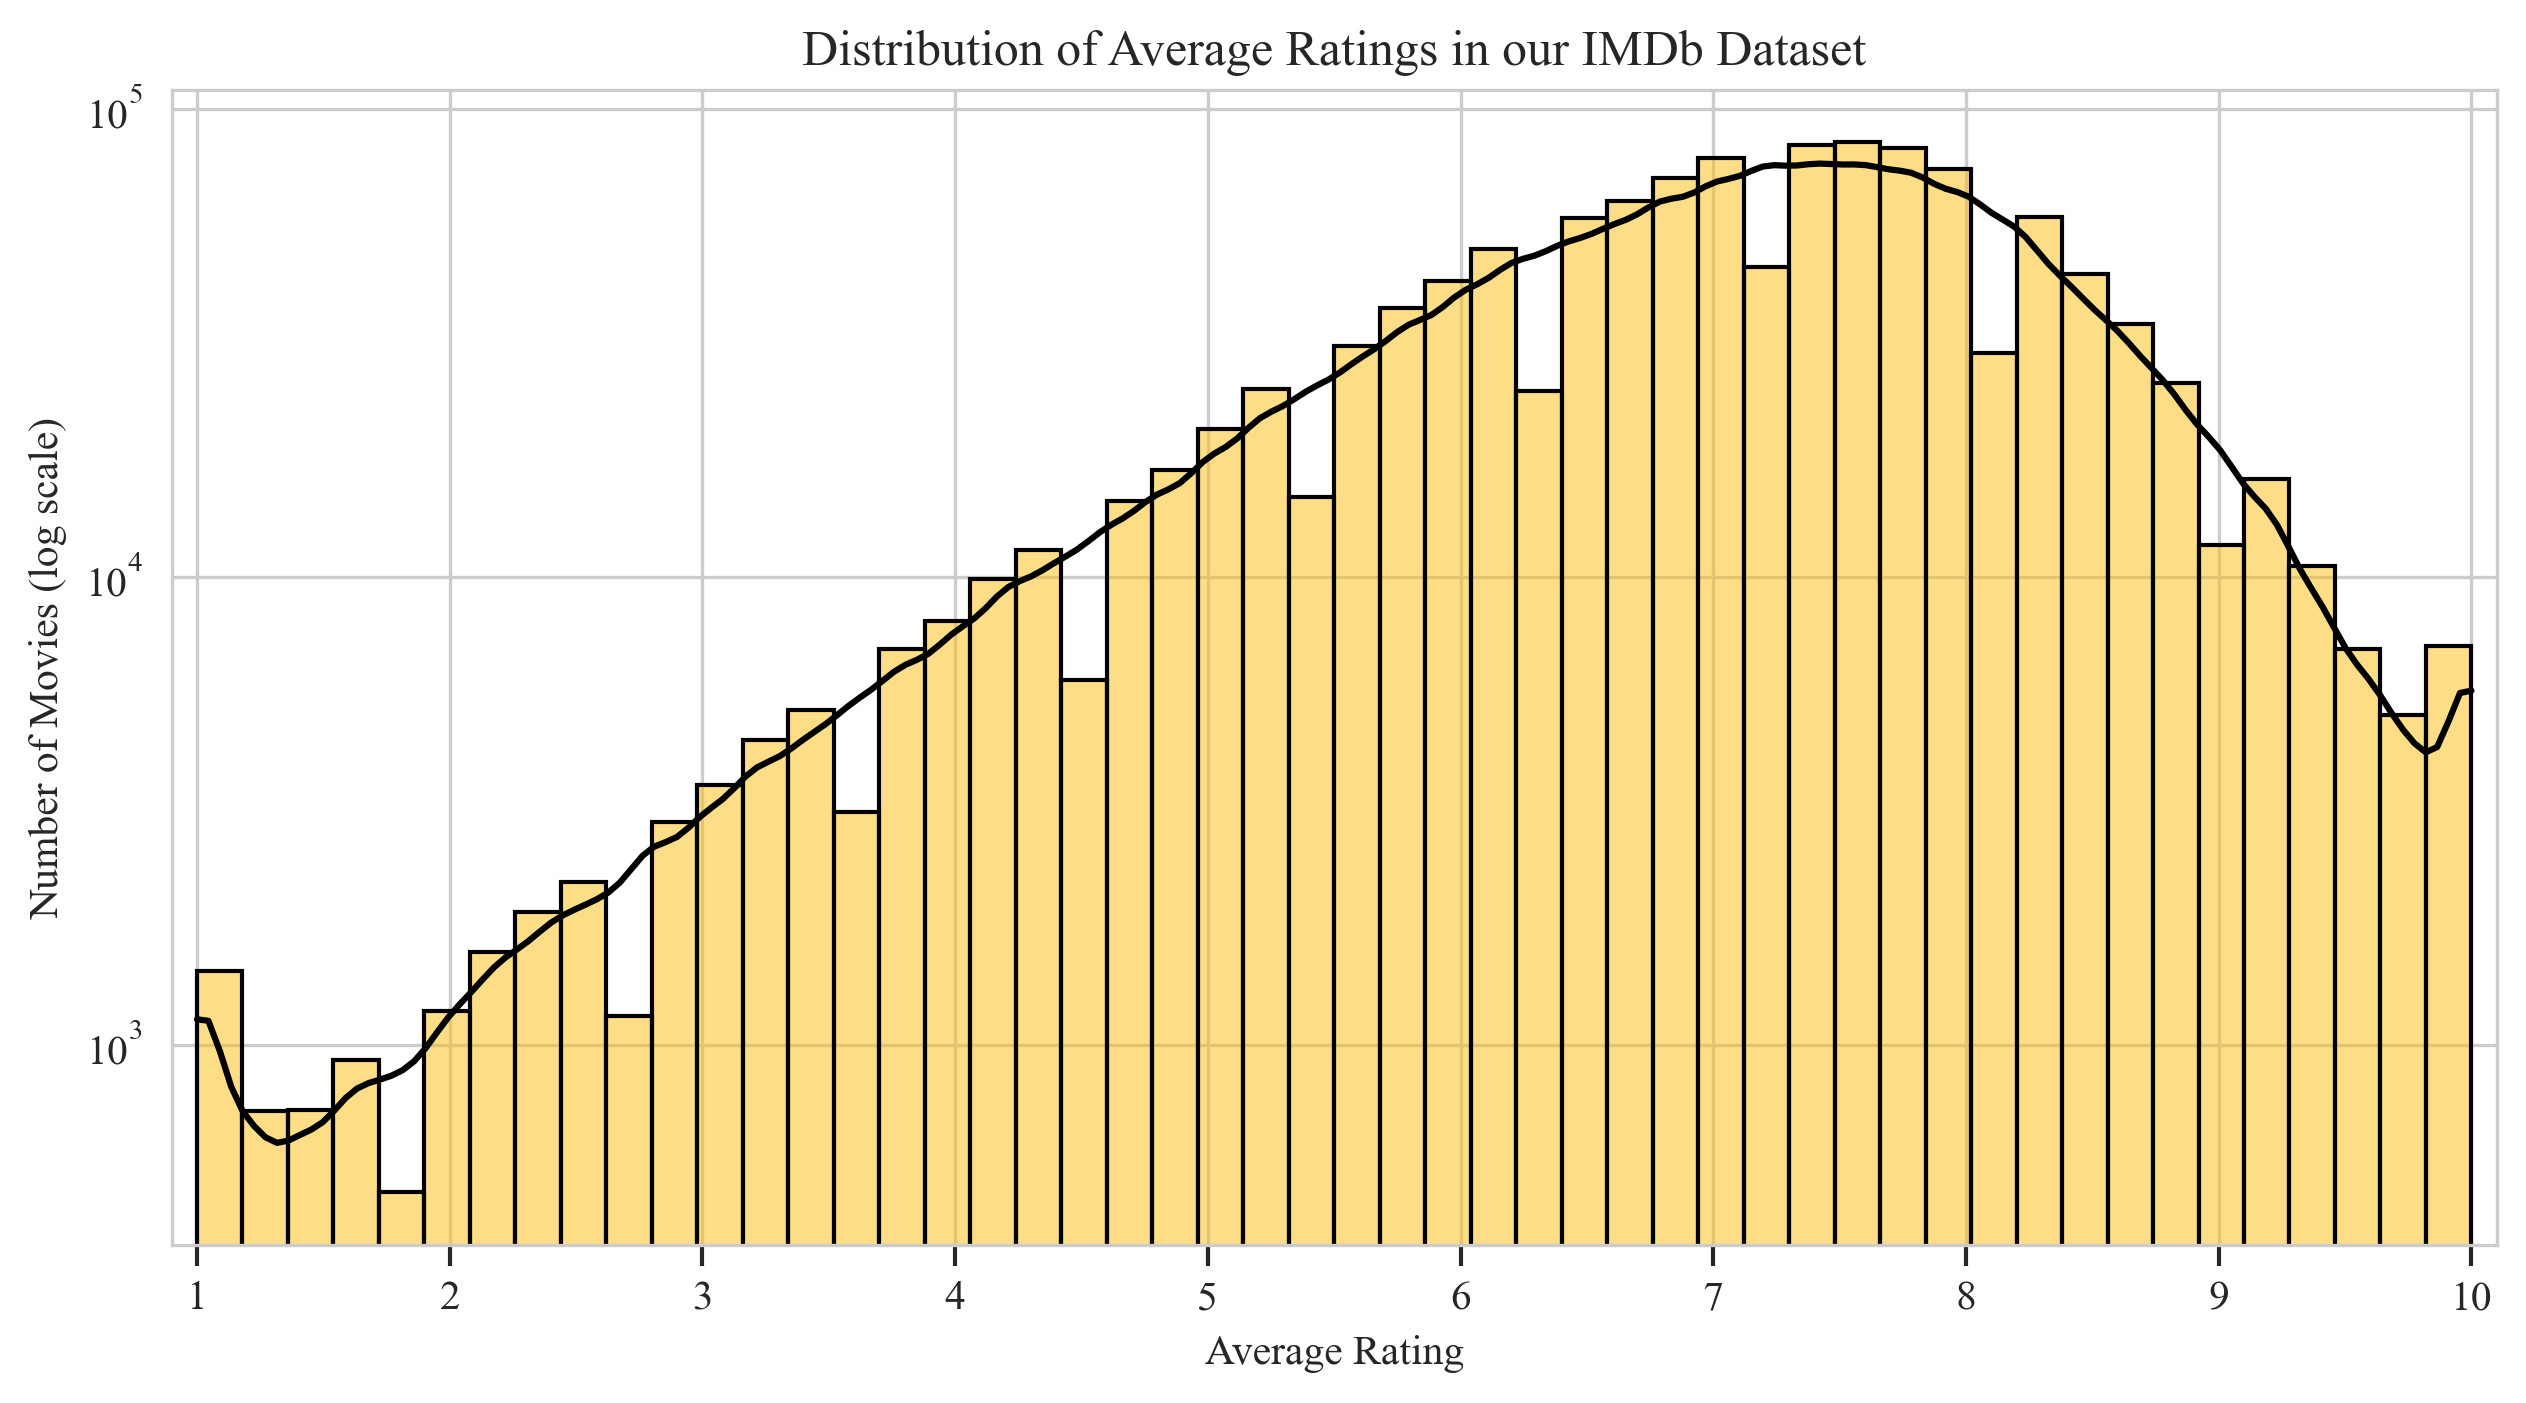

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ratings['average_rating'], bins=50, ax=ax, kde=True, color="#fcbe11")
ax.lines[0].set_color('#000')
ax.set_xlim(0.9, 10.1)
ax.set_xticks(np.arange(1, 11))
ax.set_yscale('log')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Number of Movies (log scale)')
_ = ax.set_title('Distribution of Average Ratings in our IMDb Dataset')
for patch in ax.patches:
    patch.set_edgecolor("#000")
fig.savefig('../docs/static/plots/ratings_distribution.png', bbox_inches='tight', dpi=600)

In [11]:
movie_director = pd.merge(pd.merge(director_df, is_directed_by_df, on='director_id'), movie_df, on='movie_id')[['director_id', 'birth_year', 'death_year', 'release_date', 'average_rating']]
movie_director.dropna(inplace=True)

movie_director['release_year'] = movie_director['release_date'].dt.year
movie_director.drop(['release_date'], axis=1, inplace=True)

movie_director['director_age'] = (movie_director['release_year'] - movie_director['birth_year'])
movie_director = movie_director[movie_director['director_age'] > 18]
movie_director = movie_director[movie_director['director_age'] < 100]

# a movie is a success if rating higher than threshold and release before director's death
movie_director['success'] = np.where((movie_director.average_rating > SUCCESS_THRESHOLD) & (movie_director.release_year < movie_director.death_year),1,0)

movie_director.head()

,director_id,birth_year,death_year,average_rating,release_year,director_age,success
0,nm0000005,1918,2007,7.7,1955,37,1
1,nm0000005,1918,2007,7.2,1950,32,0
2,nm0000005,1918,2007,7.1,1960,42,0
3,nm0000005,1918,2007,7.6,1982,64,1
4,nm0000005,1918,2007,6.4,1948,30,0


In [12]:
directors = {}
for director, group in movie_director.groupby(['director_id', 'success']):        
    if director[1] == 1:
        directors[director[0]] = [1, group["director_age"].min()]
    else:
        if director[0] in directors:
            continue
        else:
            directors[director[0]] = [0, group["director_age"].max()]
director_km = pd.DataFrame(directors).transpose()
director_km.rename(columns={director_km.columns[0]: 'success', director_km.columns[1]: 'success_age'}, inplace=True)
director_km.head()

,success,success_age
nm0000005,1,37
nm0000008,0,37
nm0000009,0,42
nm0000018,0,59
nm0000019,1,33


In [13]:
director_sf = sm.SurvfuncRight(director_km["success_age"], director_km["success"])

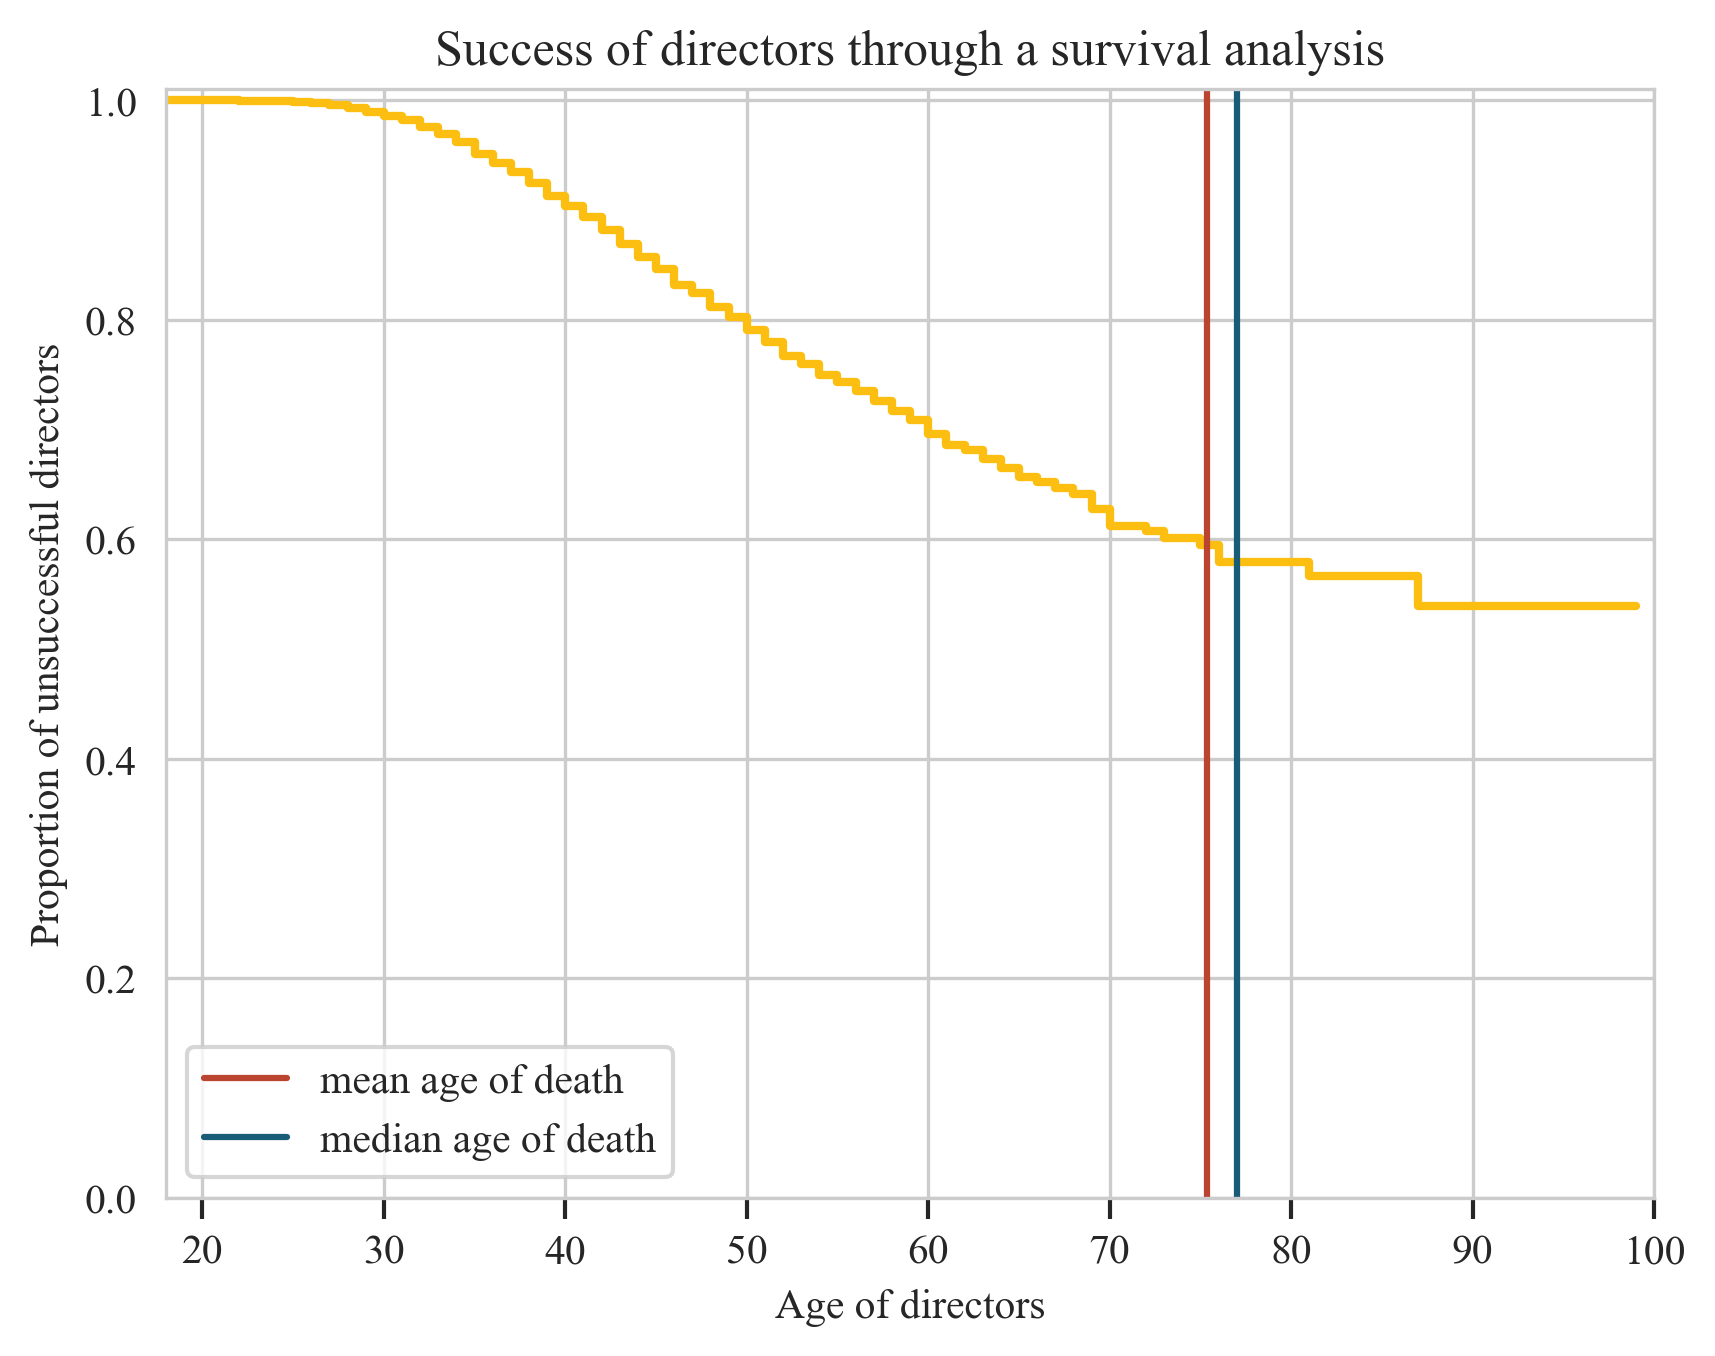

In [14]:
fig = director_sf.plot()
ax = fig.get_axes()[0]
pt = ax.get_lines()[1]
pt.set_visible(False)
ax.get_lines()[0].set_color("#fcbe11")
mean = ax.axvline((movie_director['death_year'] - movie_director['birth_year']).mean(), label='mean age of death', color='#bb4430')
median = ax.axvline((movie_director['death_year'] - movie_director['birth_year']).median(), label='median age of death', color='#185c77')
plt.xlim([18, 100])
plt.title("Success of directors through a survival analysis")
plt.xlabel("Age of directors")
plt.ylabel("Proportion of unsuccessful directors")
plt.legend(handles=[mean, median])
plt.show()
fig.savefig('../docs/static/plots/director_success.png', bbox_inches='tight', dpi=600)

In [15]:
print(f"The mean age of director deaths is{(movie_director['death_year'] - movie_director['birth_year']).mean(): .2f}, and the median age is{(movie_director['death_year'] - movie_director['birth_year']).median(): .2f}.")

The mean age of director deaths is 75.35, and the median age is 77.00.


In [16]:
movie_regression_df = movie_df.copy()
movie_regression_df.drop(["freebase_id","plot"],axis=1,inplace=True)
movie_regression_df["num_votes"] = movie_regression_df["num_votes"].astype(np.int32)

In [17]:
genre_movie_df = is_of_type_df.copy()
genre_movie_df["genre_encoding"] = genre_movie_df["genre_name"].apply(lambda g: fr.GENRE_MAPPING[g])
genre_movie_df["genre_encoding"] = genre_movie_df["genre_encoding"].apply(
    lambda l: np.sum([np.array(fr.GENRE_ENCODING[g]) for g in l],axis=0))
for genre in fr.GENRE_LIST:
    genre_movie_df[genre] = genre_movie_df["genre_encoding"].apply(
        lambda l: l[fr.GENRE_LIST.index(genre)])
    movie_regression_df[genre] = genre_movie_df.groupby("movie_id")[genre].max()
movie_regression_df["genre_number"] = genre_movie_df.groupby("movie_id")["genre_name"].count()

In [18]:
movie_regression_df["decade"] = movie_regression_df["release_date"].apply(lambda d: d.year - d.year%10)

In [19]:
rating_genre = movie_regression_df.filter(fr.GENRE_LIST+["average_rating"])
rating_genre = rating_genre[fr.GENRE_LIST].multiply(rating_genre["average_rating"], axis=0)
rating_genre.head()

,action,adventure,comedy,drama,thriller,horror,animation,children,adult,fantasy,genre
movie_id,,,,,,,,,,,
975900,4.9,4.9,0.0,0.0,4.9,4.9,0.0,0.0,0.0,4.9,0.0
28463795,0.0,0.0,0.0,5.7,5.7,0.0,0.0,0.0,0.0,0.0,0.0
261236,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10408933,0.0,0.0,6.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2345652,0.0,0.0,0.0,0.0,0.0,7.9,0.0,0.0,0.0,7.9,0.0


In [20]:
sum_rating_genre = pd.merge(rating_genre, movie_regression_df, on="movie_id", suffixes=(None, "_y"))[fr.GENRE_LIST+["decade"]].groupby("decade").sum()

In [21]:
sum_nb_genre = movie_regression_df[fr.GENRE_LIST+["decade"]].groupby("decade").sum()

In [22]:
sum_nb_genre.rename(columns={"genre": 'other'}, inplace=True)
sum_rating_genre.rename(columns={"genre": 'other'}, inplace=True)

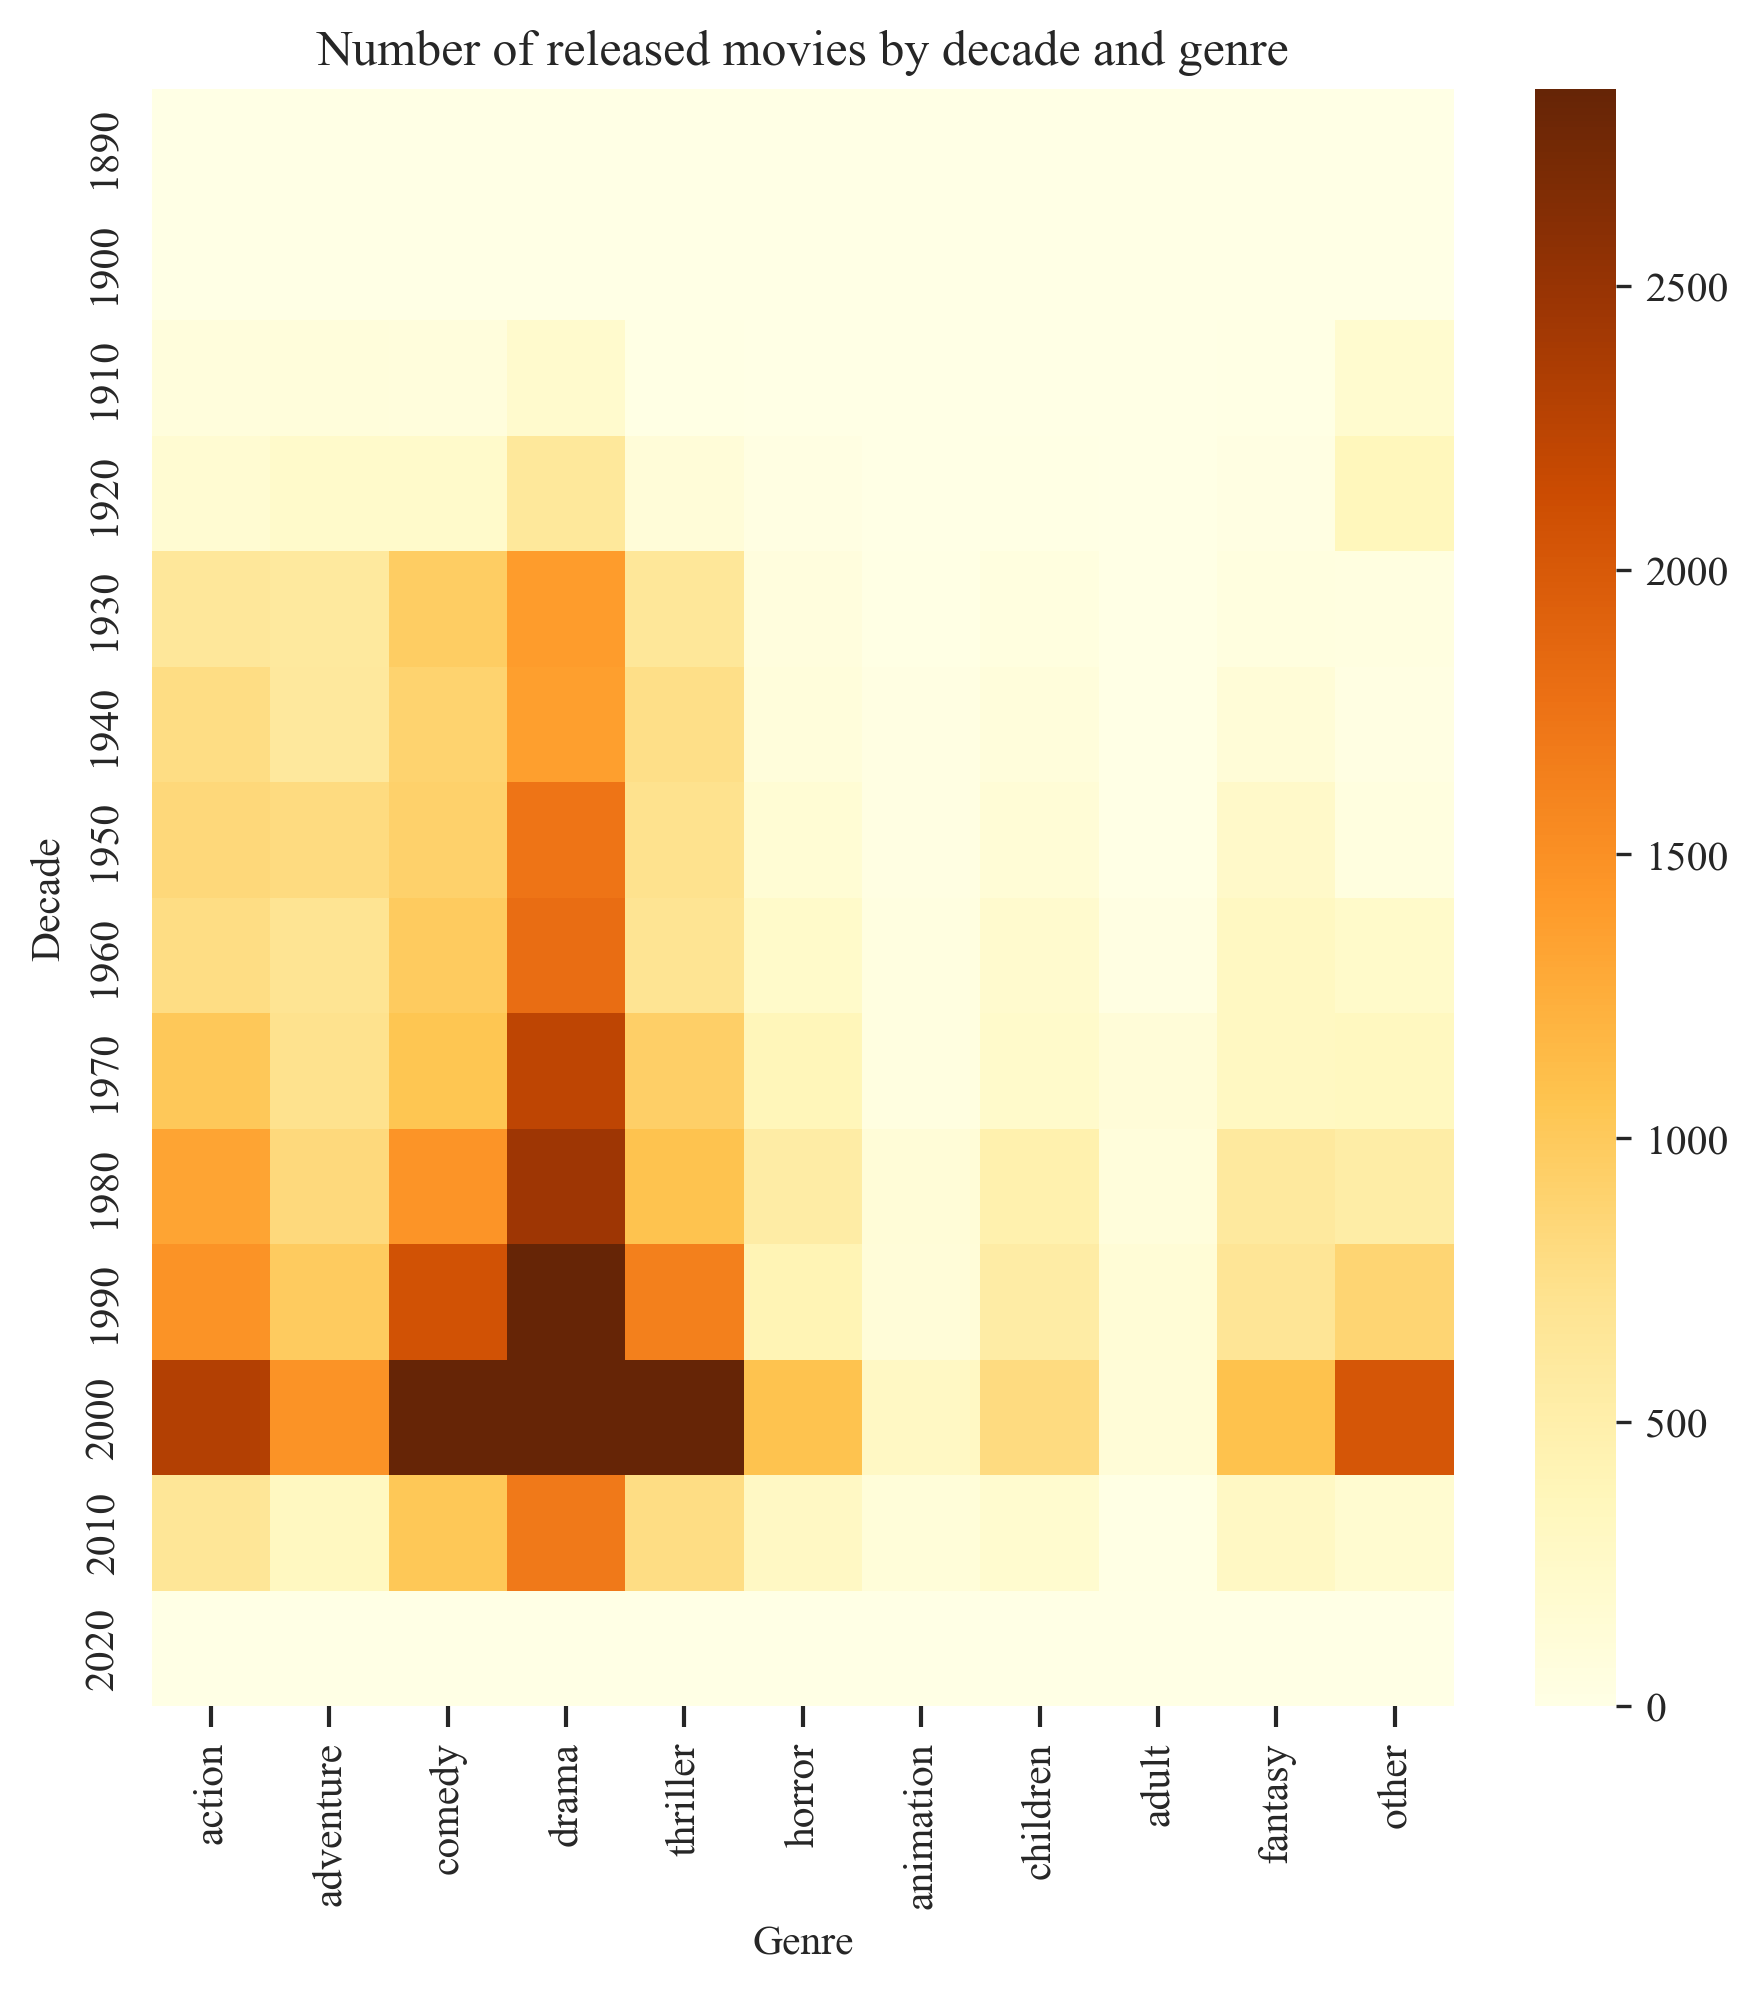

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(sum_nb_genre, robust=True, square=False, cmap="YlOrBr", ax=ax)
ax.set_title("Number of released movies by decade and genre")
ax.set_xlabel("Genre")
_ = ax.set_ylabel("Decade")
fig.savefig('../docs/static/plots/genre_heatmap_num.png', bbox_inches='tight', dpi=600)

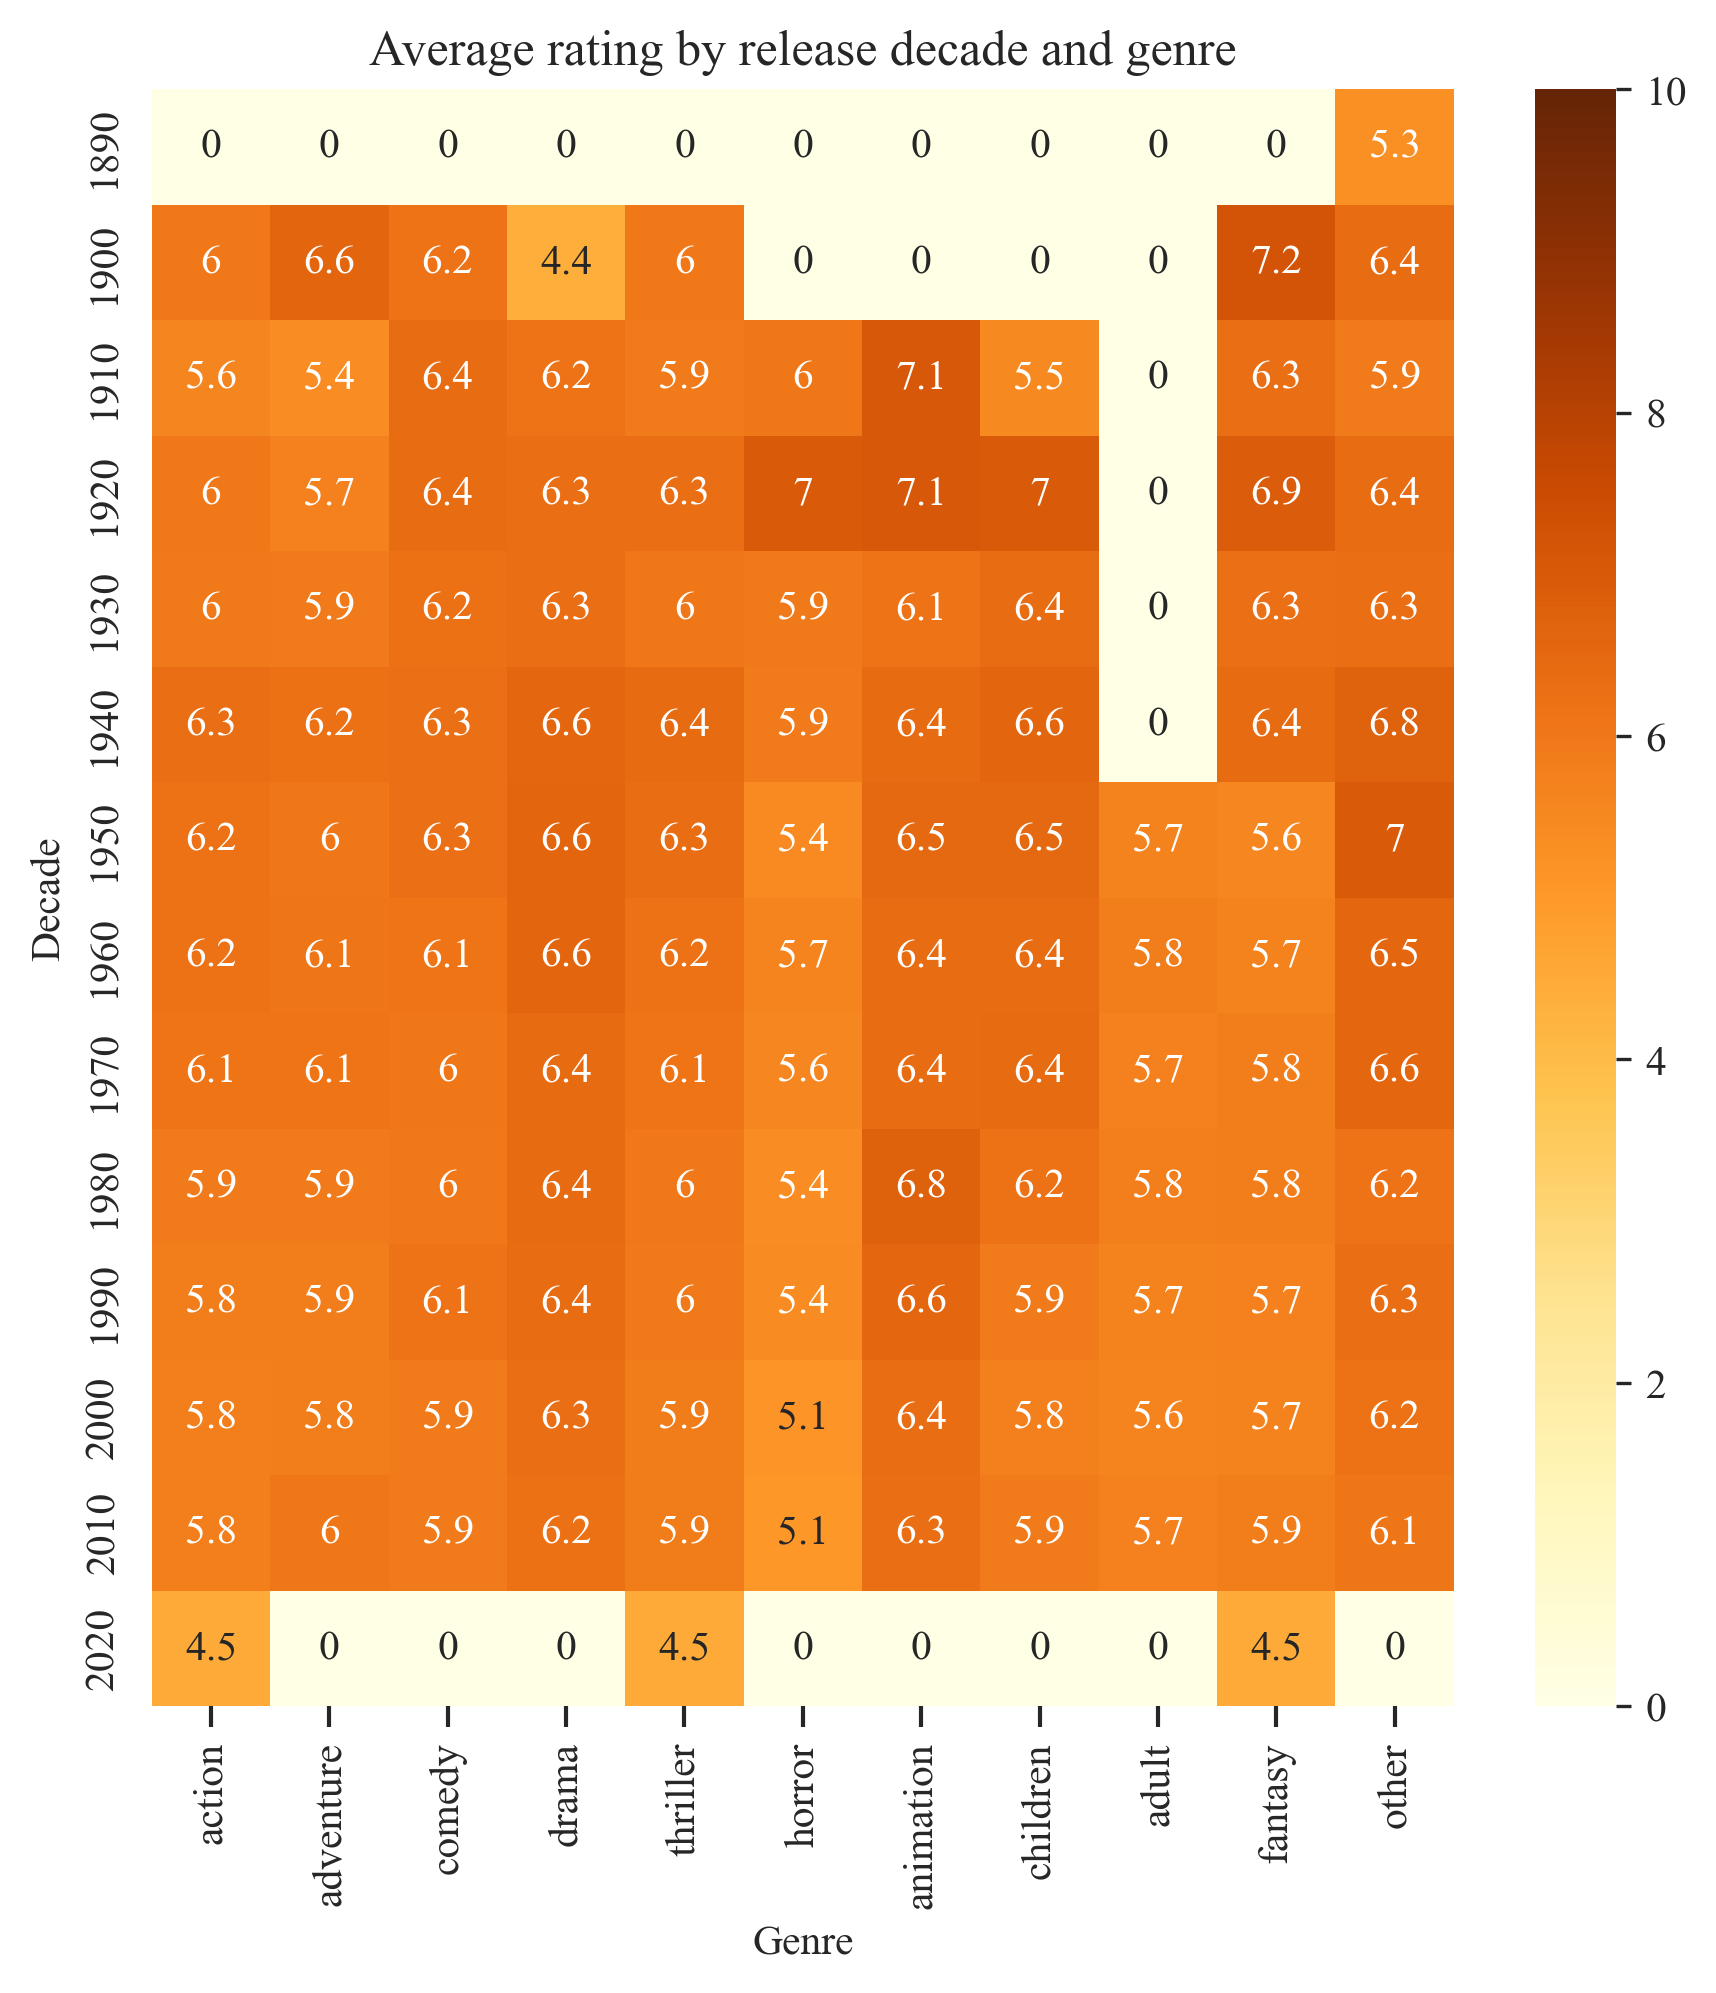

In [24]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(sum_rating_genre.divide(sum_nb_genre).fillna(0), robust=False, square=False, annot=True, vmin=0, vmax=10, cmap="YlOrBr", ax=ax)
ax.set_title("Average rating by release decade and genre")
ax.set_xlabel("Genre")
_ = ax.set_ylabel("Decade")
fig.savefig('../docs/static/plots/genre_heatmap_rating.png', bbox_inches='tight', dpi=600)

In [25]:
percentile = 99
actor_movie_count = appears_in_df.groupby("actor_id")["movie_id"].count().values
threshold = np.percentile(actor_movie_count,percentile)
is_actor_above_threshold = appears_in_df.groupby("actor_id")["movie_id"].count().sort_index() >= threshold
top_k_actors = actor_df[is_actor_above_threshold.values]
print(f"There are {len(top_k_actors)} actors in the top {percentile}%.")

There are 1014 actors in the top 99%.


In [26]:
actor_movie_df = appears_in_df.merge(actor_df["gender"],how="left",on="actor_id")
actor_movie_df["gender"] = actor_movie_df["gender"].apply(
    lambda g: -1 if g == "M" else 1 if g == "F" else g)
actor_movie_df["is_top_k"] = actor_movie_df["actor_id"].isin(set(top_k_actors.index))

In [27]:
movie_regression_df["actor_number"] = actor_movie_df.groupby("movie_id")["actor_id"].count()
movie_regression_df["mean_actor_age"] = actor_movie_df.groupby("movie_id")["actor_age"].mean()
movie_regression_df["gender_ratio"] = actor_movie_df.groupby("movie_id")["gender"].mean()
movie_regression_df["has_famous_actor"] = actor_movie_df.groupby("movie_id")["is_top_k"].max()
movie_regression_df["has_famous_actor"] = movie_regression_df["has_famous_actor"].replace({True: 1, False: 0})

In [28]:
gender_ratio = movie_regression_df.dropna(subset=['gender_ratio', 'decade'])

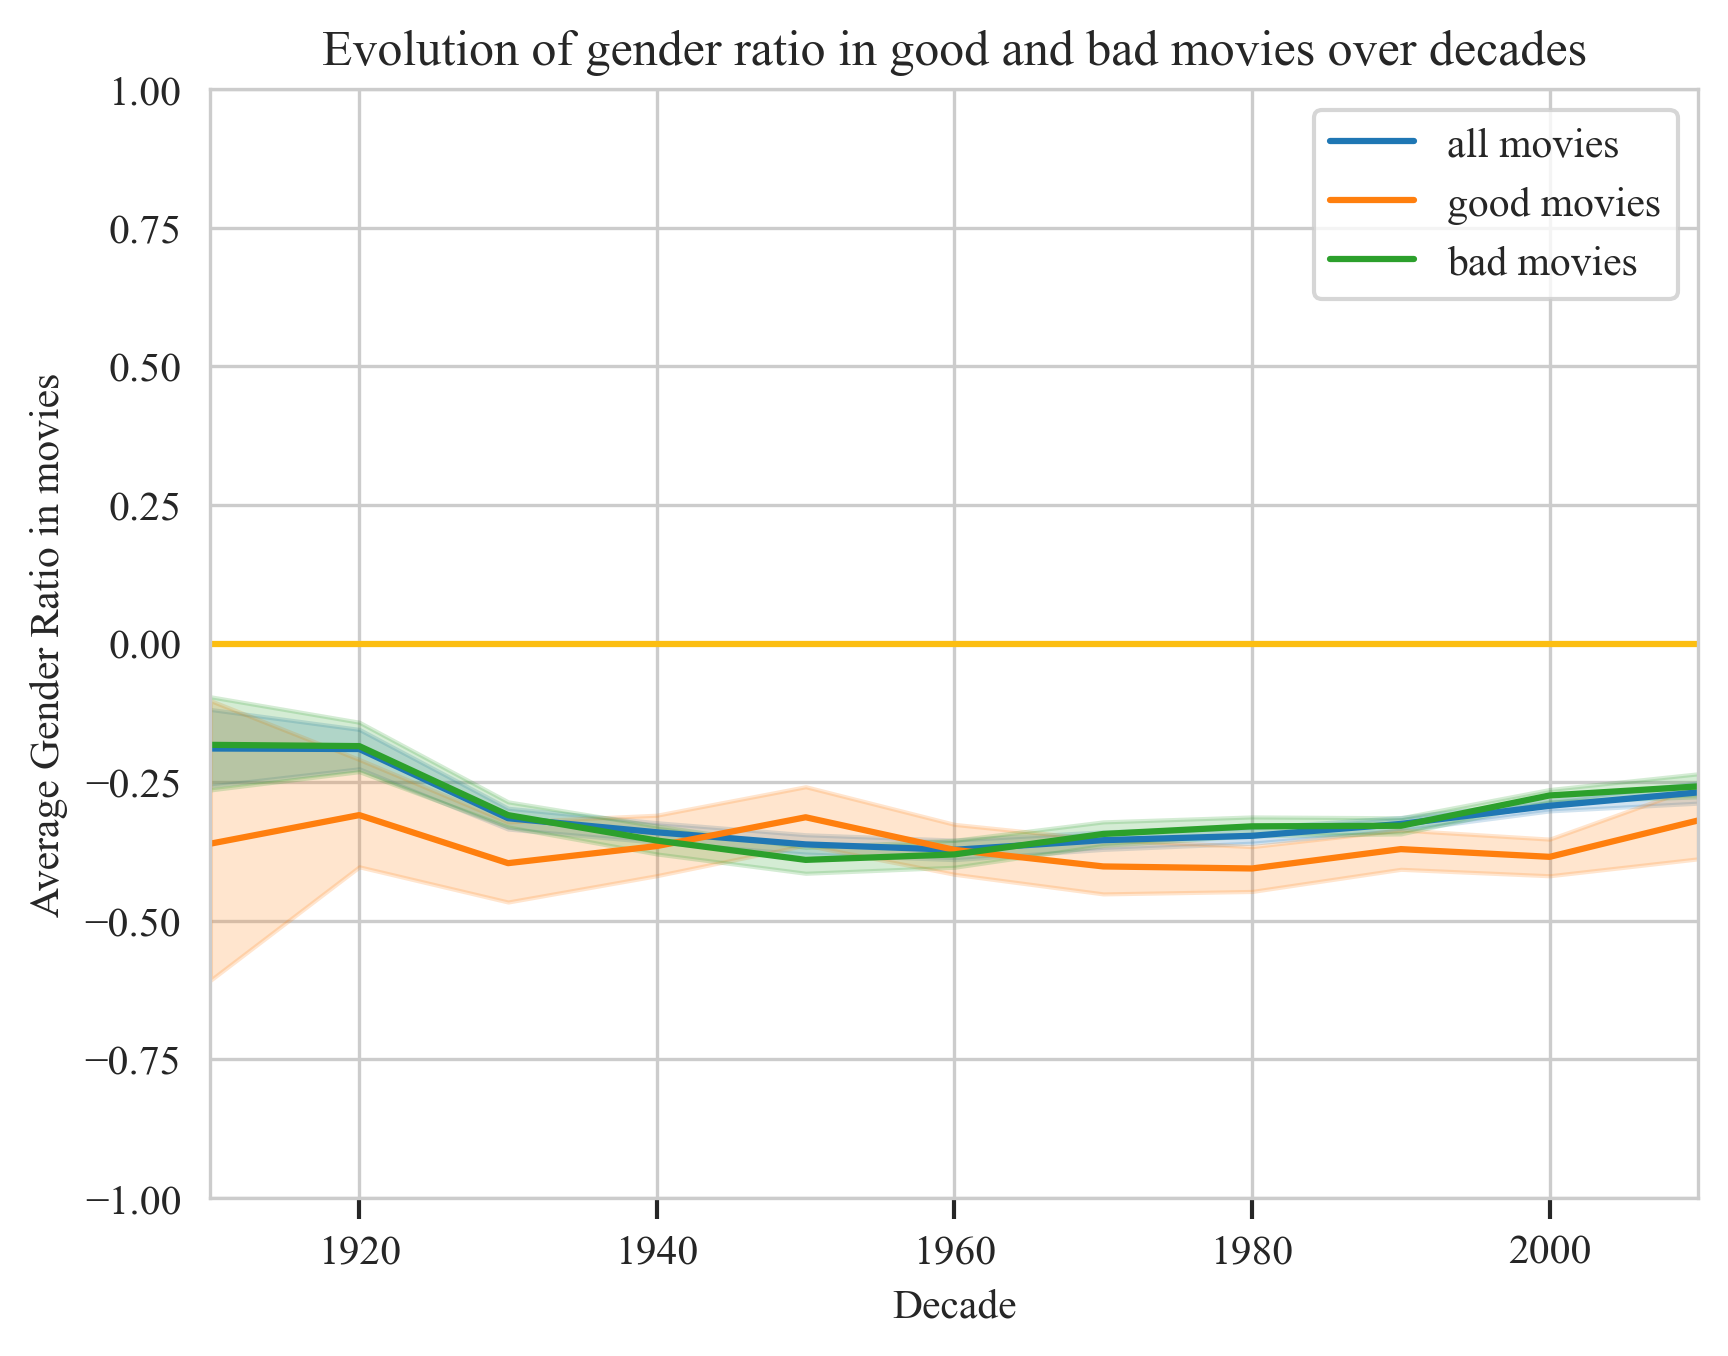

In [29]:
fig, ax = plt.subplots()
sns.lineplot(data=gender_ratio, x='decade', y='gender_ratio',legend='brief', label='all movies', ax=ax)
sns.lineplot(data=gender_ratio[gender_ratio['average_rating'] >= SUCCESS_THRESHOLD], x='decade', y='gender_ratio',legend='brief', label='good movies', ax=ax)
sns.lineplot(data=gender_ratio[gender_ratio['average_rating'] <= BAD_THRESHOLD], x='decade', y='gender_ratio',legend='brief', label='bad movies', ax=ax)
ax.axhline(0, color='#fcbe11')
ax.set_xlabel('Decade')
ax.set_ylabel('Average Gender Ratio in movies')
ax.set_xlim([1910, 2010])
ax.set_ylim([-1, 1])
ax.set_title('Evolution of gender ratio in good and bad movies over decades')
_ = plt.legend()
fig.savefig('../docs/static/plots/genreratio.png', bbox_inches='tight', dpi=600)

In [30]:
#Load the budget data and prepare it to merge it with processed_df
budget_df = pd.read_csv("../data/imdb/imdb-movies.csv")
budget_df = budget_df[['imdb_id', 'budget']]
budget_df = budget_df[budget_df.budget != 0]
mapping = pd.read_pickle("../data/generated/wikipedia_imdb_mapping_df.pkl")
mapping = mapping.reset_index()
mapping.rename(columns = {'tconst':'imdb_id'}, inplace = True)
budget_df = mapping.merge(budget_df)

In [31]:
ratings.rename(columns = {'tconst':'imdb_id'}, inplace = True)

In [32]:
rating_budget_df = pd.merge(ratings, budget_df, on="imdb_id", suffixes=(None, "_y"))

In [33]:
rating_budget_df

,imdb_id,average_rating,num_votes,movie_id,budget
0,tt0052646,4.5,7109,1771762,62000
1,tt0053604,8.3,181829,43849,3000000
2,tt0053716,5.9,3548,3373525,3000000
3,tt0053925,6.9,13733,5421694,270000
4,tt0054033,6.2,18387,325206,30000
...,...,...,...,...,...
3819,tt2357129,6.0,98895,35304421,12000000
3820,tt2357291,6.3,91317,35140909,103000000
3821,tt2404463,6.6,173295,36389682,43000000
3822,tt2918436,5.2,44140,27677235,3300000


In [34]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [35]:
r2(rating_budget_df["budget"], rating_budget_df["average_rating"])

0.0007238685702174115

In [36]:
cutoff = np.median(rating_budget_df["budget"])

In [37]:
# add column for high budget
rating_budget_df["high_budget"] = rating_budget_df["budget"] > cutoff

<AxesSubplot:xlabel='high_budget', ylabel='average_rating'>

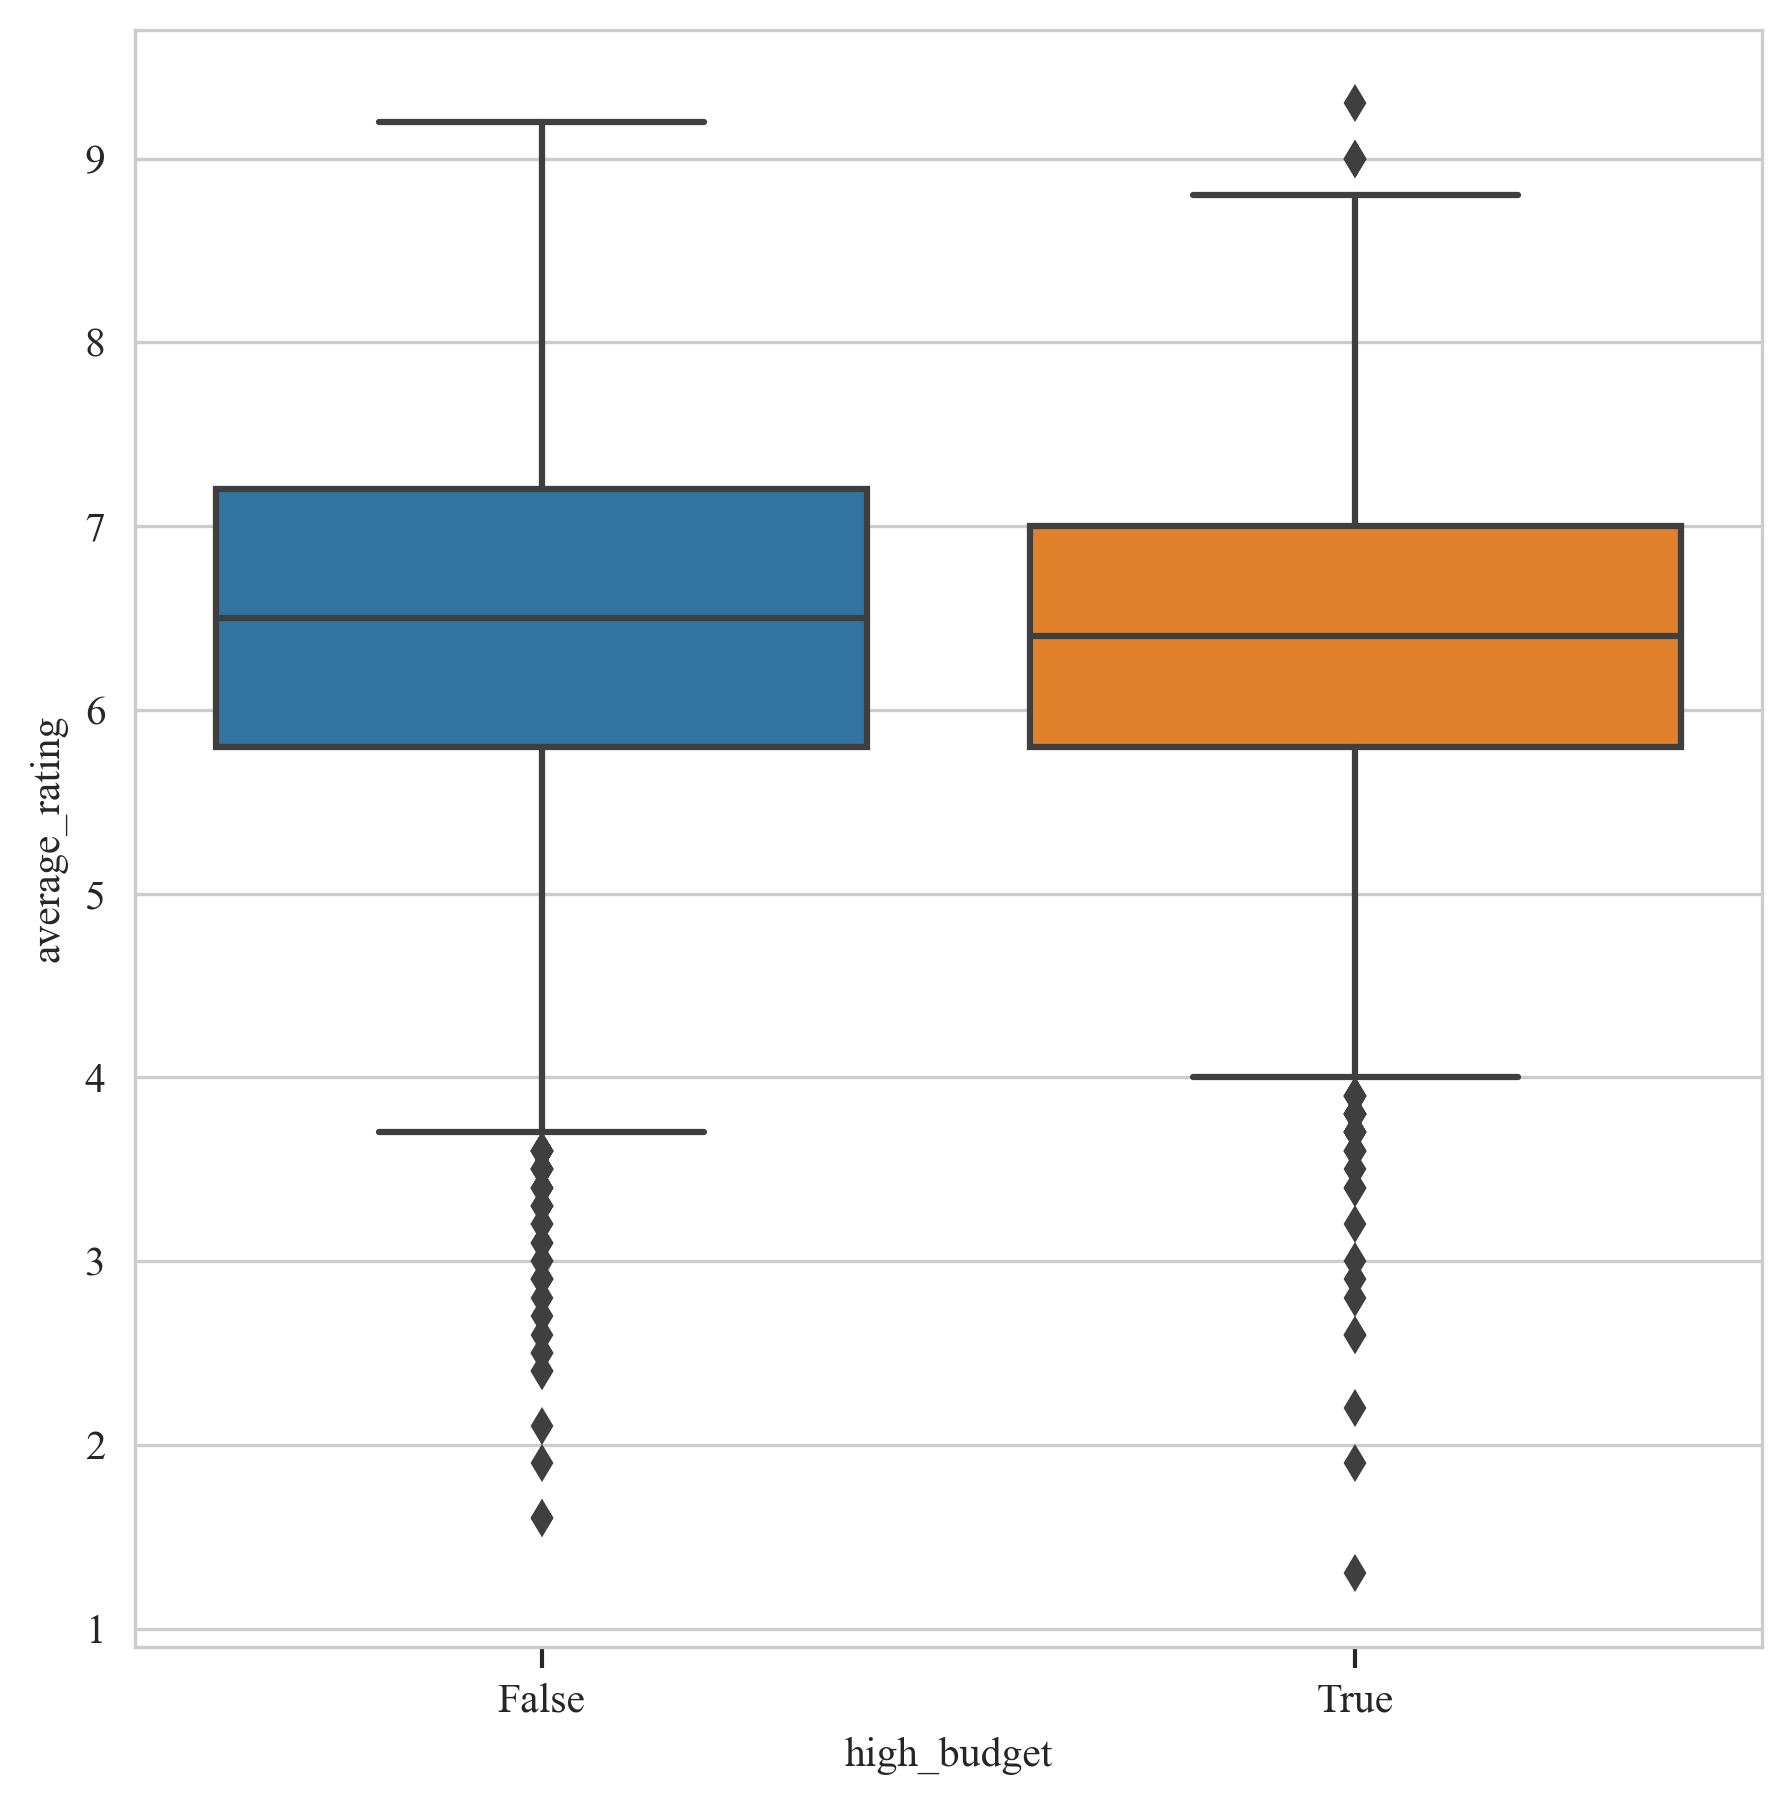

In [38]:
# boxplot of ratings by budget
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(y="average_rating", x="high_budget", data=rating_budget_df, ax=ax)

In [39]:
# add for bad movies
rating_budget_df["bad_movie"] = rating_budget_df["average_rating"] < 6.5

<AxesSubplot:xlabel='bad_movie', ylabel='budget'>

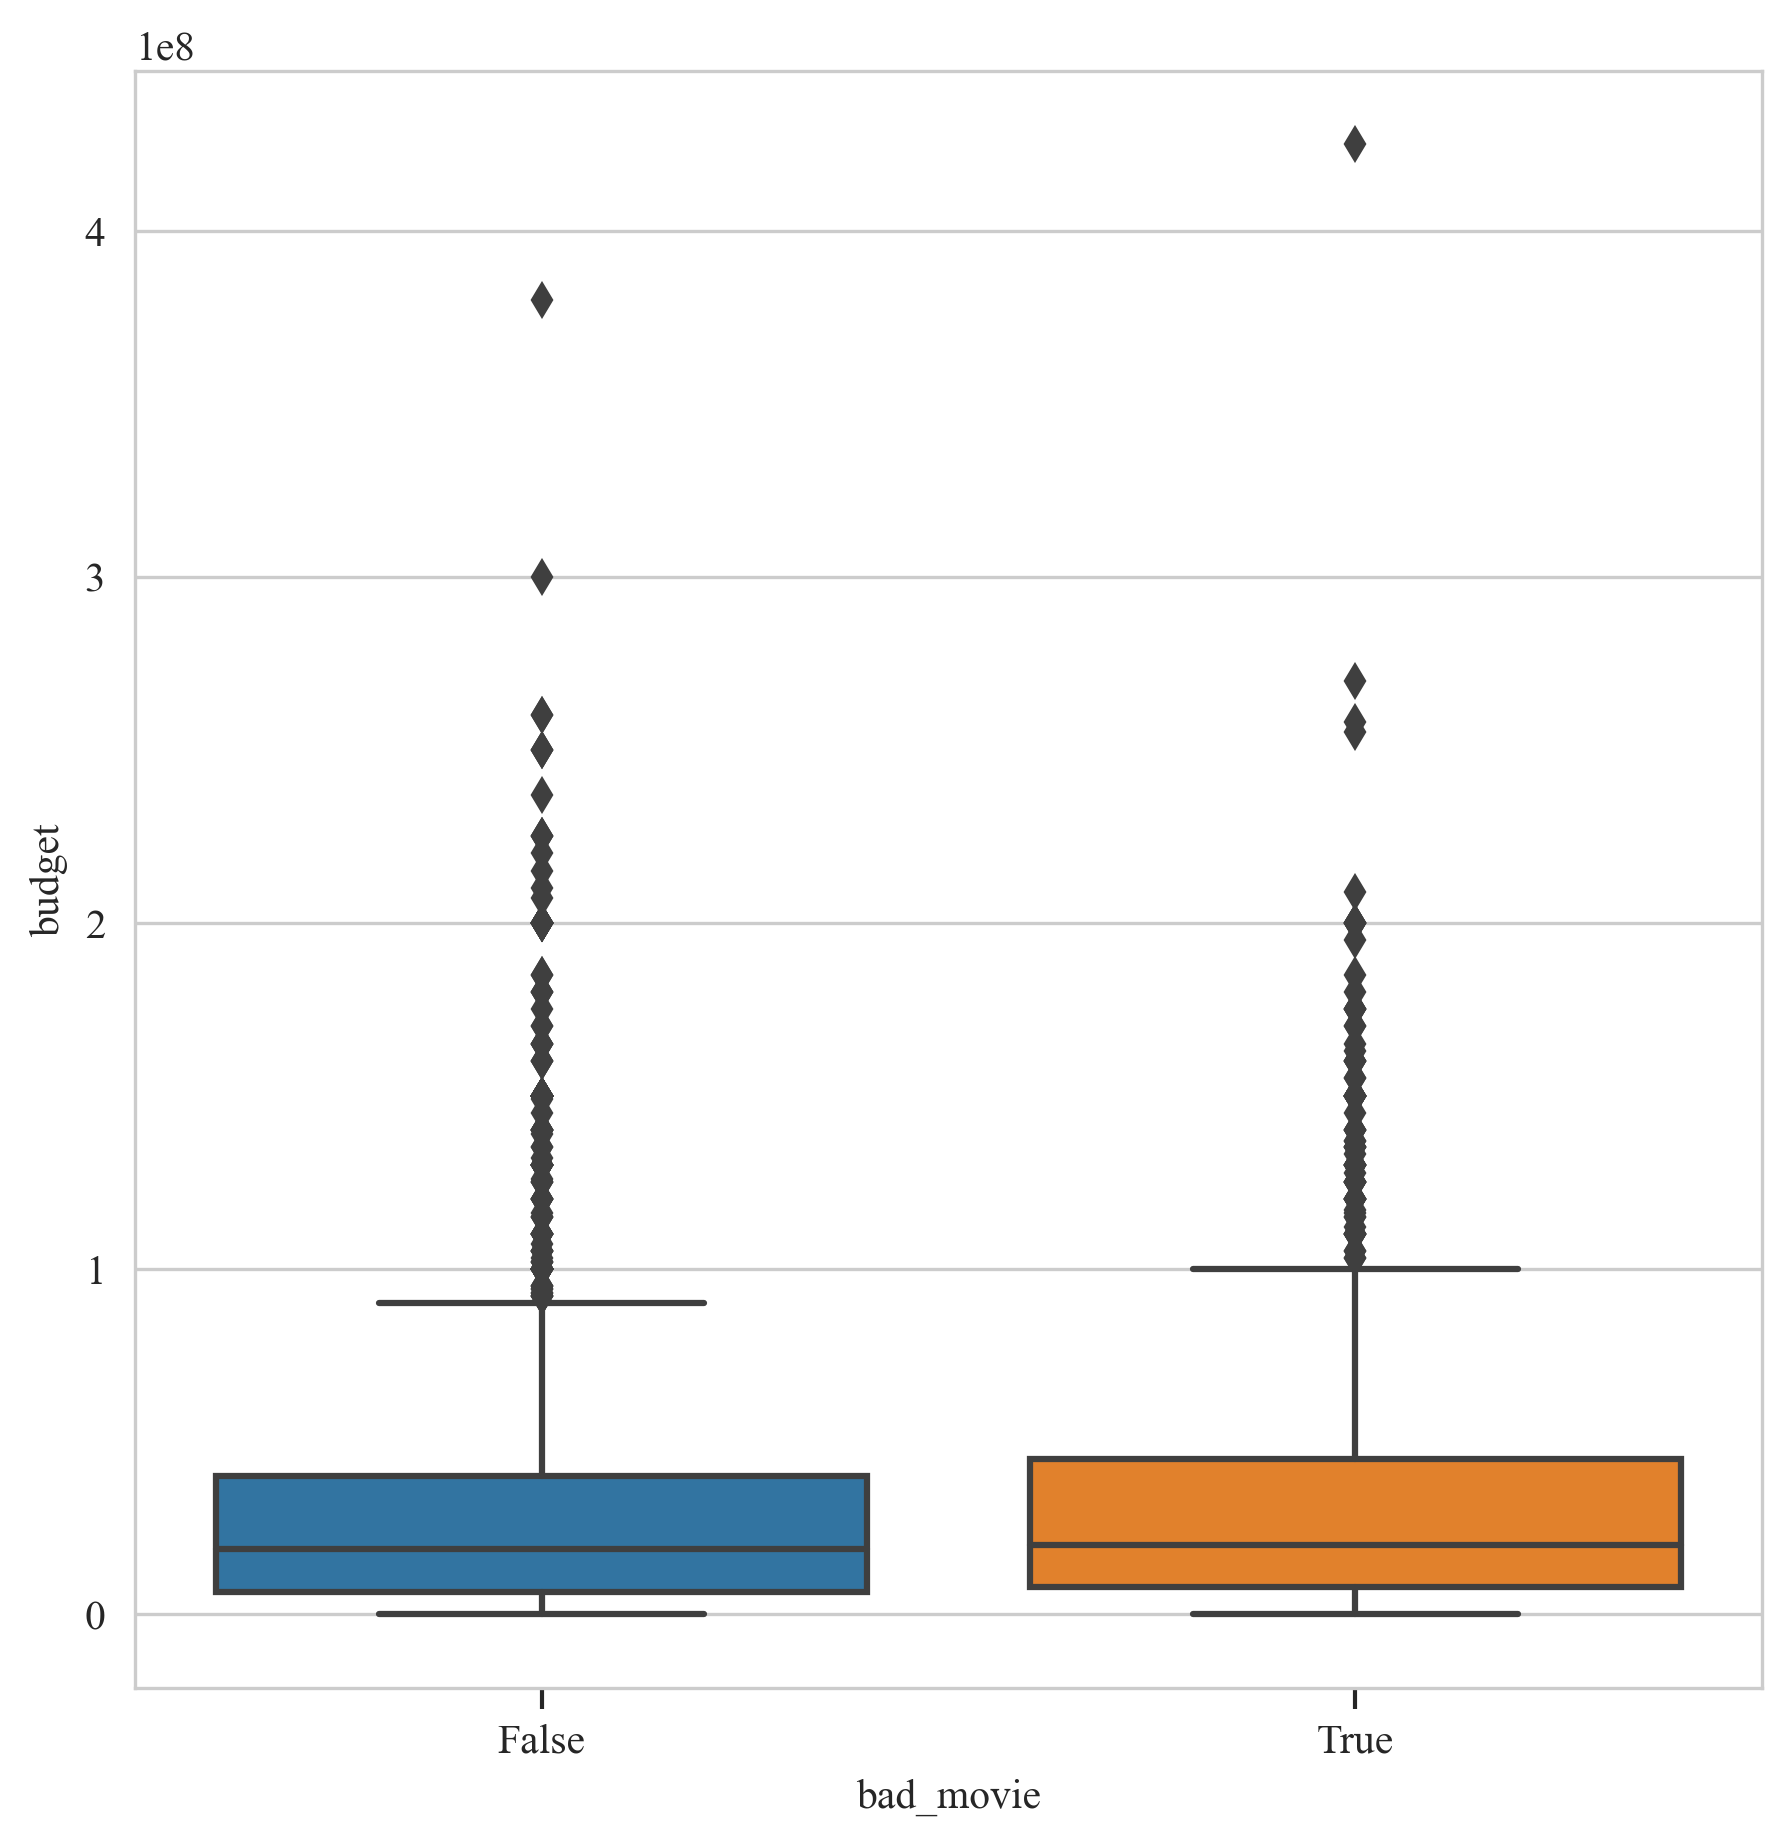

In [40]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(y="budget", x="bad_movie", data=rating_budget_df, ax=ax)